In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import platform
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import time
import os

In [23]:
# ==============================
# 1. 环境配置和超参数设置
# ==============================
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda:0


In [24]:
# 实验超参数
config = {
    'batch_size': 128,          # 每次迭代训练的样本数量
    'learning_rate': 0.001,     # 优化器的学习率，控制参数更新幅度
    'num_epochs': 15,           # 训练总轮数（完整遍历训练集的次数）
    'num_workers': 4,           # 数据加载时使用的进程数，加速数据预处理
    'optimizer': 'Adam',        # 选择的优化器（这里指定为Adam）
    'pretrained': True,         # 是否使用预训练模型的权重
    'data_augmentation': True   # 是否对训练数据进行数据增强
}

In [25]:
# 创建结果保存目录
os.makedirs('results',exist_ok=True)
os.makedirs('checkpoints',exist_ok=True)

In [26]:
# ==============================
# 2. 数据预处理和加载
# ==============================
# 数据增强和归一化
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 随机裁剪：先填充4像素再裁回32x32，增加边缘信息多样性
    transforms.RandomHorizontalFlip(),     # 50%概率水平翻转，增强视角鲁棒性
    transforms.ToTensor(),                 # 转换为PyTorch张量（0-255→0-1）
    transforms.Normalize(                  # 标准化：(像素值-均值)/标准差
        (0.4914, 0.4822, 0.4465),          # CIFAR-10 RGB通道均值
        (0.2023, 0.1994, 0.2010)           # CIFAR-10 RGB通道标准差
    )
]) if config['data_augmentation'] else transforms.Compose([
    # 不启用数据增强时，仅做张量转换和标准化
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 测试集转换（无数据增强）
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [27]:
# 下载并加载CIFAR-10数据集
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',       # 数据保存路径
    train=True,          # 加载训练集（50000张图片）
    download=True,       # 本地无数据则自动下载
    transform=transform_train  # 应用训练集转换
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,         # 加载测试集（10000张图片）
    download=True, 
    transform=transform_test   # 应用测试集转换
)

In [28]:
# 划分训练集和验证集 (90% 训练, 10% 验证)
train_subset, val_subset = random_split(train_dataset, [0.9,0.1])

In [29]:
# 验证集使用测试集transform（无数据增强）
val_subset.dataset.transform = transform_test

In [30]:
# 数据加载器
train_loader = DataLoader(
    train_subset,
    batch_size=config['batch_size'],  # 每批128张图片
    shuffle=True,                     # 训练集打乱顺序，增强随机性
    num_workers=config['num_workers'] # 4个进程并行加载数据
)
val_loader = DataLoader(
    val_subset, 
    batch_size=config['batch_size'],
    shuffle=False,                    # 验证集无需打乱
    num_workers=config['num_workers']
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=config['batch_size'],
    shuffle=False,                    # 测试集按顺序加载
    num_workers=config['num_workers']
)


In [31]:
# CIFAR-10类别名称
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

In [38]:
# ==============================
# 3. 模型定义 - 修改ResNet-18
# ==============================
class CustomResNet18(nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()

        # 加载预训练ResNet-18
        self.model = torchvision.models.resnet18(pretrained=config['pretrained'])
        
        # 修改第一层卷积：适配CIFAR-10的32x32输入
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.bn1 = nn.BatchNorm2d(64)
        
        # 修改最后的全连接层
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [40]:
# 创建模型并移至设备
model = CustomResNet18(num_classes=10).to(device)

# 打印模型结构
print("模型结构:")
print(model)

模型结构:
CustomResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [41]:
# ==============================
# 4. 损失函数和优化器
# ==============================
criterion = nn.CrossEntropyLoss()  # 内部包含LogSoftmax和NLLLoss
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

# 学习率调度器 - 移除verbose参数以兼容旧版本
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2)  # 移除verbose参数

In [42]:
# ==============================
# 5. 训练和验证函数
# ==============================
def train(epoch):
    model.train()  # 将模型切换到训练模式
    running_loss = 0.0  # 累计损失值
    correct = 0         # 累计正确预测数
    total = 0           # 累计总样本数

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)  # 将数据移至指定设备

        # 前向传播
        outputs = model(inputs)  # 模型预测：(batch_size, 10)的logits
        loss = criterion(outputs, targets)  # 计算损失

        # 反向传播和优化
        optimizer.zero_grad()  # 清空梯度缓存
        loss.backward()        # 反向传播计算梯度
        optimizer.step()       # 优化器更新模型参数

        # 统计信息
        running_loss += loss.item()  # 累加损失（.item()将张量转为Python数值）
        _, predicted = outputs.max(1)  # 取每个样本的最大预测值索引（即预测类别）
        total += targets.size(0)       # 累加总样本数（当前批次的样本数）
        correct += predicted.eq(targets).sum().item()  # 累加正确预测数

        if batch_idx % 100 == 99:  # 每100个批次输出一次中间结果
            print(f'Epoch: {epoch+1} | Batch: {batch_idx+1}/{len(train_loader)} | '
                  f'Loss: {running_loss/(batch_idx+1):.4f} | Acc: {100.*correct/total:.2f}%')
        
    train_loss = running_loss / len(train_loader)  # 计算整个epoch的平均损失
    train_acc = 100. * correct / total             # 计算整个epoch的准确率
    return train_loss, train_acc


In [43]:
def validate(loader):
    model.eval()  # 将模型切换到评估模式
    val_loss = 0.0  # 累计验证损失
    correct = 0     # 累计正确预测数
    total = 0       # 累计总样本数

    with torch.no_grad():
    # 循环处理数据加载器中的批次
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)  # 数据移至目标设备

            outputs = model(inputs)  # 模型预测（仅前向传播）
            loss = criterion(outputs, targets)  # 计算当前批次的损失

            val_loss += loss.item()  # 累加损失值
            _, predicted = outputs.max(1)  # 获取预测类别（最大概率对应的索引）
            total += targets.size(0)       # 累加总样本数
            correct += predicted.eq(targets).sum().item()  # 累加正确预测数

    val_loss /= len(loader)  # 计算整个数据集的平均损失
    val_acc = 100. * correct / total  # 计算整体准确率

    print(f'Validation | Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%')
    return val_loss, val_acc


In [44]:
# ==============================
# 6. 训练循环和结果记录
# ==============================
# 初始化记录变量
train_losses = []    # 存储每轮训练的平均损失
train_accs = []      # 存储每轮训练的准确率
val_losses = []      # 存储每轮验证的平均损失
val_accs = []        # 存储每轮验证的准确率
best_acc = 0.0       # 记录验证集上的最佳准确率（用于保存最佳模型）

start_time = time.time()  # 记录训练开始时间

print("开始训练...")
for epoch in range(config['num_epochs']):  # 遍历所有训练轮次（config中设置为15轮）
    # 训练当前轮次并返回指标
    train_loss, train_acc = train(epoch)
    # 在验证集上评估并返回指标
    val_loss, val_acc = validate(val_loader)  # 使用验证集评估
    
    # 更新学习率
    scheduler.step(val_acc)
    
    # 保存训练过程
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # 保存最佳模型
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), f'checkpoints/best_model.pth')
        print(f'保存最佳模型，准确率: {best_acc:.2f}%')

# 保存最终模型
torch.save(model.state_dict(), f'checkpoints/final_model.pth')
print(f"训练完成! 总耗时: {time.time()-start_time:.2f}秒")

开始训练...
Epoch: 1 | Batch: 100/352 | Loss: 1.4923 | Acc: 46.96%
Epoch: 1 | Batch: 200/352 | Loss: 1.2667 | Acc: 55.09%
Epoch: 1 | Batch: 300/352 | Loss: 1.1289 | Acc: 60.21%
Validation | Loss: 0.9154 | Acc: 67.88%
保存最佳模型，准确率: 67.88%
Epoch: 2 | Batch: 100/352 | Loss: 0.6359 | Acc: 78.32%
Epoch: 2 | Batch: 200/352 | Loss: 0.6410 | Acc: 78.08%
Epoch: 2 | Batch: 300/352 | Loss: 0.6284 | Acc: 78.63%
Validation | Loss: 0.6636 | Acc: 77.24%
保存最佳模型，准确率: 77.24%
Epoch: 3 | Batch: 100/352 | Loss: 0.4153 | Acc: 85.95%
Epoch: 3 | Batch: 200/352 | Loss: 0.4290 | Acc: 85.50%
Epoch: 3 | Batch: 300/352 | Loss: 0.4341 | Acc: 85.17%
Validation | Loss: 0.5930 | Acc: 79.14%
保存最佳模型，准确率: 79.14%
Epoch: 4 | Batch: 100/352 | Loss: 0.2853 | Acc: 90.27%
Epoch: 4 | Batch: 200/352 | Loss: 0.3008 | Acc: 89.79%
Epoch: 4 | Batch: 300/352 | Loss: 0.3106 | Acc: 89.45%
Validation | Loss: 0.5643 | Acc: 81.36%
保存最佳模型，准确率: 81.36%
Epoch: 5 | Batch: 100/352 | Loss: 0.1917 | Acc: 93.34%
Epoch: 5 | Batch: 200/352 | Loss: 0.2092 

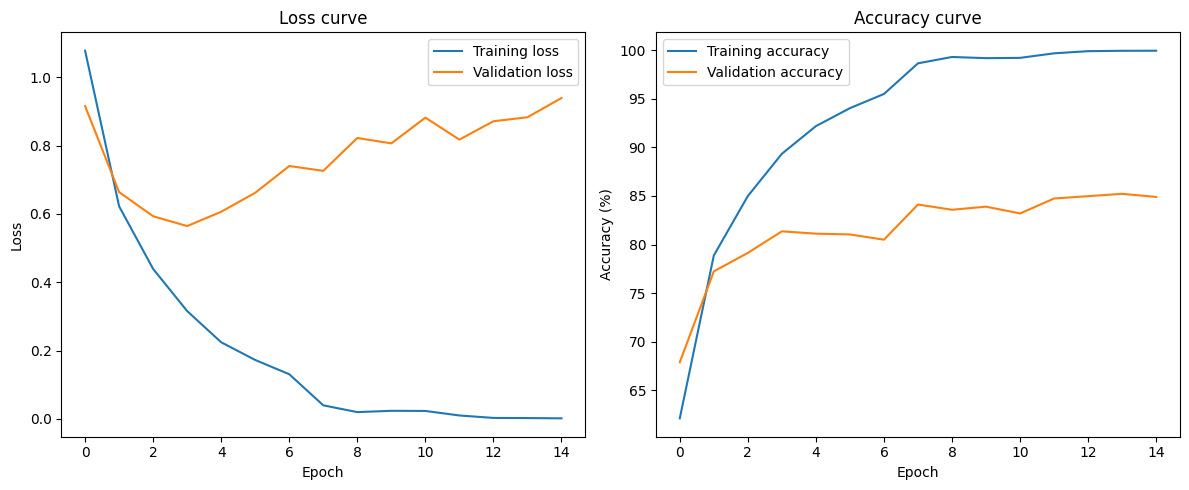

Validation | Loss: 0.9709 | Acc: 84.64%


In [ ]:
# ==============================
# 7. 结果可视化和分析
# ==============================
# 绘制学习曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('results/learning_curves.png')
plt.show()
# plt.close()

# 在测试集上评估最终模型
model.load_state_dict(torch.load('checkpoints/best_model.pth'))
test_loss, test_acc = validate(test_loader)  # 使用测试集

<function matplotlib.pyplot.show(close=None, block=None)>

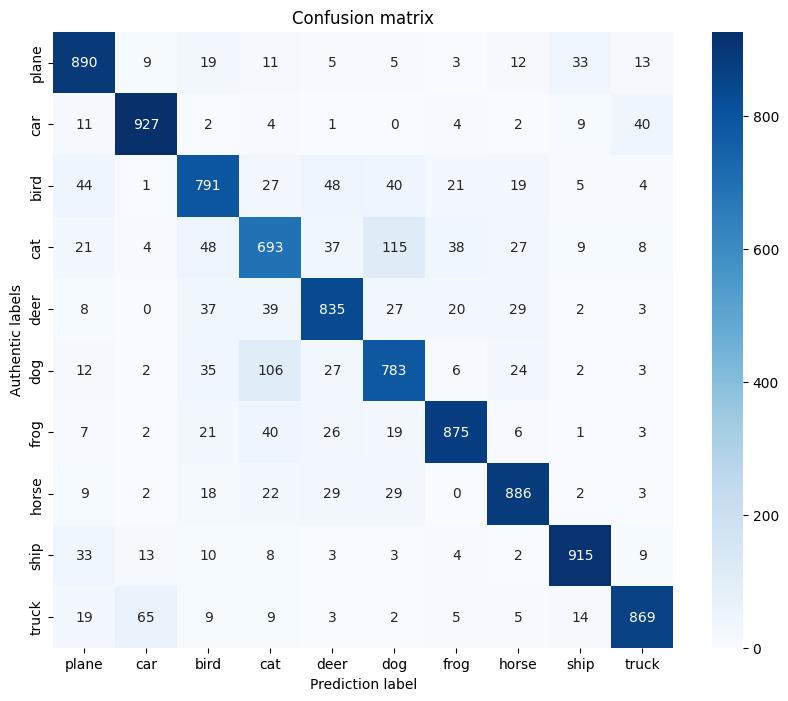

In [53]:
# 生成混淆矩阵
all_targets = []  # 存储所有测试样本的真实标签
all_preds = []    # 存储所有测试样本的预测标签

model.eval()  # 切换到评估模式
with torch.no_grad():  # 关闭梯度计算
    for images, labels in test_loader:
        # 将数据移至模型所在设备
        images, labels = images.to(device), labels.to(device)
        
        # 前向传播获取预测结果
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # 取预测概率最大的类别
        
        # 将标签从GPU转移到CPU，并转换为NumPy数组，存入列表
        all_targets.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(10, 8))  # 设置画布大小

# 用热力图可视化混淆矩阵
sns.heatmap(cm, 
            annot=True,        # 在热力图上显示具体数值
            fmt='d',           # 数值格式为整数（d表示decimal）
            cmap='Blues',      # 颜色主题（蓝色系，数值越大颜色越深）
            xticklabels=classes,  # x轴标签：类别名称（如'plane'、'car'）
            yticklabels=classes   # y轴标签：类别名称
           )

# 添加标题和坐标轴标签
plt.title('Confusion matrix')
plt.xlabel('Prediction label')  # x轴：预测标签
plt.ylabel('Authentic labels')  # y轴：真实标签（注："Authentic"更规范的说法是"True"）

# 保存图像并关闭画布
plt.savefig('results/confusion_matrix.png')
plt.show
# plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5885309..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.7988244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.675763..1.8476002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38462442..1.6720076].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6466857..1.4542255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6697937..1.330576].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.704840

<function matplotlib.pyplot.show(close=None, block=None)>

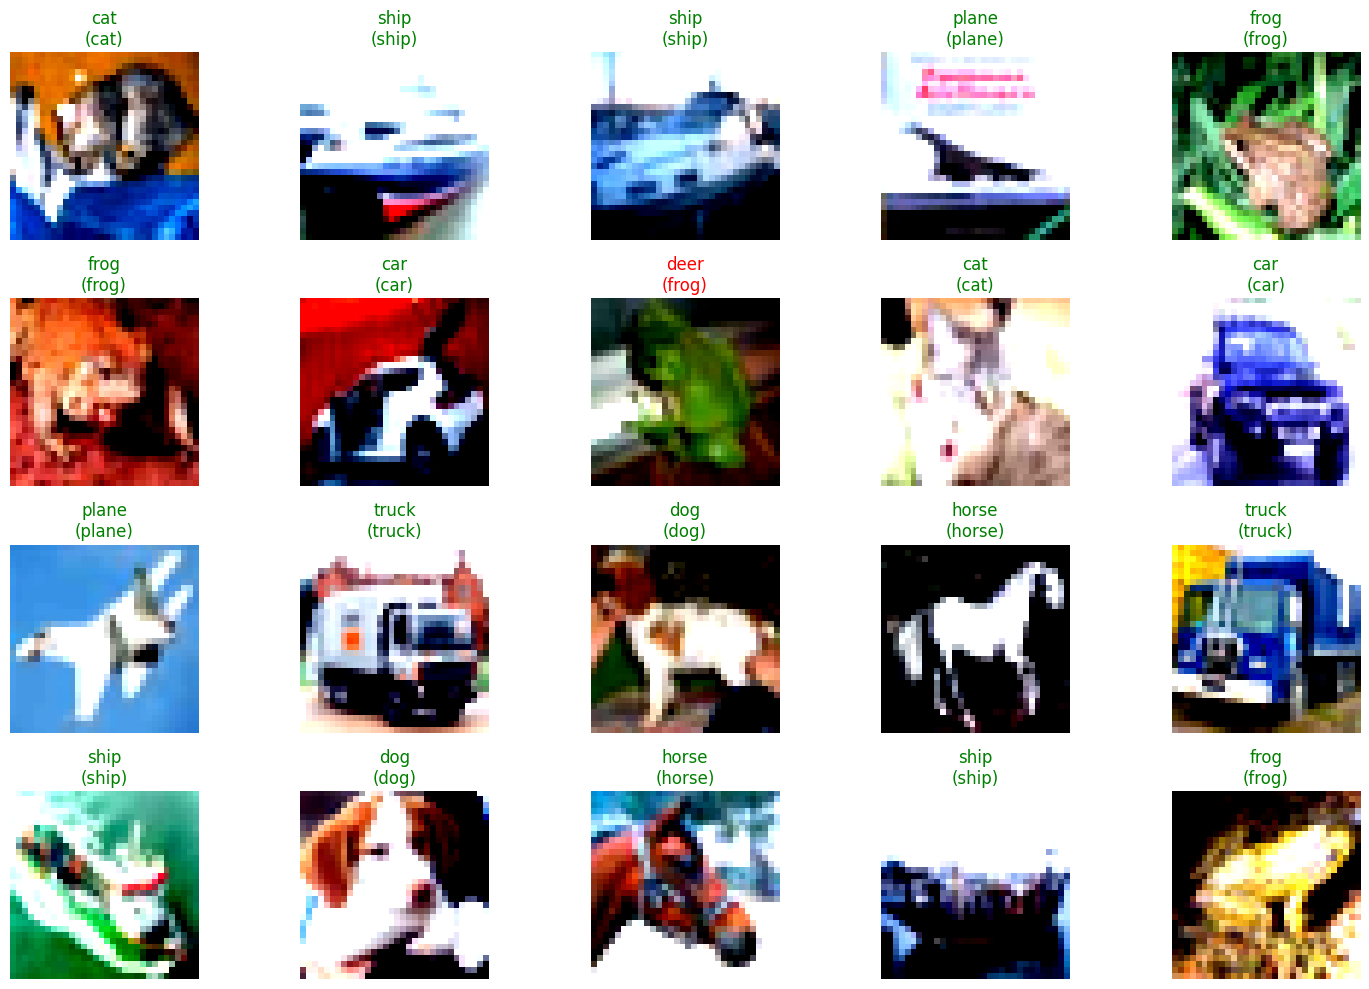

In [54]:
# 保存类别准确率
class_acc = {}  # 用字典存储每个类别的准确率
for i in range(10):
    # 计算第i类的准确率：该类被正确预测的样本数 / 该类的总样本数 * 100（转为百分比）
    class_acc[classes[i]] = cm[i, i] / cm[i].sum() * 100

# 可视化一些预测结果
def imshow(img):
    img = img / 2 + 0.5  # 反归一化：将之前标准化的图像恢复到[0,1]范围
    npimg = img.numpy()  # 转换为NumPy数组
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # 调整维度顺序：从PyTorch的(C,H,W)转为图像的(H,W,C)
    plt.axis('off')  # 关闭坐标轴，让图像更整洁

# 获取一批测试图像
dataiter = iter(test_loader)  # 创建测试集迭代器
images, labels = next(dataiter)  # 获取一个批次的图像和标签
images, labels = images.cpu(), labels.cpu()  # 移至CPU（方便显示）

# 显示图像和预测
outputs = model(images.to(device))  # 图像移至模型所在设备并预测
_, predicted = torch.max(outputs, 1)  # 获取预测类别

# 绘制预测结果
plt.figure(figsize=(15, 10))  # 创建画布，设置大小
for i in range(20):  # 显示20张图像
    plt.subplot(4, 5, i+1)  # 4行5列的布局
    imshow(images[i])  # 显示第i张图像
    
    # 标题显示预测类别和真实类别，正确为绿色，错误为红色
    color = 'green' if predicted[i] == labels[i] else 'red'
    plt.title(f'{classes[predicted[i]]}\n({classes[labels[i]]})', color=color)

plt.tight_layout()  # 自动调整子图间距
plt.savefig('results/predictions.png')
plt.show
# plt.close()

In [ ]:
# ==============================
# 8. 生成实验报告
# ==============================
report = f"""
{'='*50}
实验报告: 基于ResNet-18的CIFAR-10图像分类
{'='*50}

1. 运行环境
   - 操作系统: {platform.system()}
   - Python版本: {platform.python_version()}
   - PyTorch版本: {torch.__version__}
   - CUDA版本: {torch.version.cuda if torch.cuda.is_available() else 'N/A'}
   - GPU型号: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}

2. 网络结构
   - 基础模型: ResNet-18
   - 修改部分:
       1. 第一层卷积: kernel_size=3, stride=1, padding=1 (适应32x32输入)
       2. 添加BatchNorm层
       3. 最后一层全连接层: 输出维度10 (对应10个类别)
   - 残差学习: 通过短路连接解决深层网络梯度消失问题
   - 总参数量: {sum(p.numel() for p in model.parameters()):,}

3. 数据处理
   - 训练集增强: {'是' if config['data_augmentation'] else '否'}
        - 随机裁剪 (32x32, padding=4)
        - 随机水平翻转
   - 归一化: 使用CIFAR-10的均值和标准差
   - 数据集划分:
        - 训练集: {len(train_subset)} 样本
        - 验证集: {len(val_subset)} 样本
        - 测试集: {len(test_dataset)} 样本

4. 损失函数
   - CrossEntropyLoss: 适用于多分类任务，结合了LogSoftmax和NLLLoss

5. 实验设置
   | 超参数         | 值          |
   |----------------|------------|
   | Batch Size     | {config['batch_size']} |
   | Learning Rate  | {config['learning_rate']} |
   | Optimizer      | {config['optimizer']} |
   | Epochs         | {config['num_epochs']} |
   | 预训练         | {'是' if config['pretrained'] else '否'} |
   | 数据增强       | {'是' if config['data_augmentation'] else '否'} |

6. 实验结果
   - 最佳验证准确率: {best_acc:.2f}%
   - 测试准确率: {test_acc:.2f}%
   - 类别准确率:
        {pd.Series(class_acc).to_string()}

7. 分析
   - 学习曲线: 已保存至 results/learning_curves.png
   - 混淆矩阵: 已保存至 results/confusion_matrix.png
   - 预测示例: 已保存至 results/predictions.png

8. 修复的问题
   - 修复ReduceLROnPlateau的verbose参数错误
   - 添加了正确的验证集划分
   - 更新环境信息收集方式
   - 分离验证集和测试集评估

{'='*50}
实验完成! 模型和结果已保存至 checkpoints/ 和 results/ 目录
{'='*50}
"""

print(report)
with open('results/experiment_report.txt', 'w') as f:
    f.write(report)


实验报告: 基于ResNet-18的CIFAR-10图像分类

1. 运行环境
   - 操作系统: Linux
   - Python版本: 3.12.11
   - PyTorch版本: 2.8.0+cu129
   - CUDA版本: 12.9
   - GPU型号: NVIDIA GeForce RTX 5070 Ti Laptop GPU

2. 网络结构
   - 基础模型: ResNet-18
   - 修改部分:
       1. 第一层卷积: kernel_size=3, stride=1, padding=1 (适应32x32输入)
       2. 添加BatchNorm层
       3. 最后一层全连接层: 输出维度10 (对应10个类别)
   - 残差学习: 通过短路连接解决深层网络梯度消失问题
   - 总参数量: 11,173,962

3. 数据处理
   - 训练集增强: 是
        - 随机裁剪 (32x32, padding=4)
        - 随机水平翻转
   - 归一化: 使用CIFAR-10的均值和标准差
   - 数据集划分:
        - 训练集: 45000 样本
        - 验证集: 5000 样本
        - 测试集: 10000 样本

4. 损失函数
   - CrossEntropyLoss: 适用于多分类任务，结合了LogSoftmax和NLLLoss

5. 实验设置
   | 超参数         | 值          |
   |----------------|------------|
   | Batch Size     | 128 |
   | Learning Rate  | 0.001 |
   | Optimizer      | Adam |
   | Epochs         | 15 |
   | 预训练         | 是 |
   | 数据增强       | 是 |

6. 实验结果
   - 最佳验证准确率: 85.22%
   - 测试准确率: 84.64%
   - 类别准确率:
    plane    89.0
car      92.7
bird     79.1
cat      69.3
de